# Data-driven power rankings

Ranking the teams by their strength is a very important piece of information your model should use.

Some of the rankings are using expert opinion (i.e. majority vote of fan opinion). However, this may be not the best approach, as human opinions tend to be biased towards their favorites. Moreover, it may be easy to determine a top few strong teams, but it is a much harder to rank teams in the mid-lower range ranks.

In NCAA tournament teams are assigned with tournament starting seeds, which also has expert bias - it is not uncommon, that a team with higher win ratio % would get lower seed compared to a team with lower win ratio %, based on the regular season schedule (which is not the same for every team!). Therefore, the judgment of team strength of assigned seed sometimes get controversial opinion among fans and media!

The idea of this kernel is to try to calculate the team strength rankings only based on the  data we have in our disposal. This way we will eliminate all possible human biases and get a robust estimate of team's strength.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

seeds = pd.read_csv('../input/datafiles/NCAATourneySeeds.csv')
tourney_results = pd.read_csv('../input/datafiles/NCAATourneyCompactResults.csv')
regular_results = pd.read_csv('../input/datafiles/RegularSeasonCompactResults.csv')

We are going to use the function which allows us to duplicate the data by swapping the order of teams in given tables:

In [2]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'         
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).sort_index().reset_index(drop=True)
    
    return output

In [3]:
tourney_results = prepare_data(tourney_results)
regular_results = prepare_data(regular_results)

In [4]:
regular_results.head(10)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,20,1328,64,1228,81,N,0
2,1985,25,1354,70,1106,77,A,0
3,1985,25,1106,77,1354,70,H,0
4,1985,25,1112,63,1223,56,H,0
5,1985,25,1223,56,1112,63,A,0
6,1985,25,1165,70,1432,54,H,0
7,1985,25,1432,54,1165,70,A,0
8,1985,25,1192,86,1447,74,H,0
9,1985,25,1447,74,1192,86,A,0


As you can see, at this point we have clean tables with duplicated rows, but only team positions and their scores swapped.

What we are going to do next is pretty simple - we are going to make dummy features based on `T1_TeamID` and `T2_TeamID` and feed them as factors the `glm` model.

In [5]:
# convert to str, so the model would treat TeamID them as factors
regular_results['T1_TeamID'] = regular_results['T1_TeamID'].astype(str)
regular_results['T2_TeamID'] = regular_results['T2_TeamID'].astype(str)

# make it a binary task
regular_results['win'] = np.where(regular_results['T1_Score']>regular_results['T2_Score'], 1, 0)

def team_quality(season):
    """
    Calculate team quality for each season seperately. 
    Team strength changes from season to season (students playing change!)
    So pooling everything would be bad approach!
    """
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_results.loc[regular_results.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    # extracting parameters from glm
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','beta']
    quality['Season'] = season
    # taking exp due to binomial model being used
    quality['quality'] = np.exp(quality['beta'])
    # only interested in glm parameters with T1_, as T2_ should be mirroring T1_ ones
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

So what is done here - we are running a logistic regression with *N* teams in T1_x position and *N* teams in T2_x position as binary features (each feature being either "0" or "1").

"0" is representing that the team did not play in that match at the position T1 (or T2 respectively), and "1" would represent that this team actually played.

So among *N* \* 2 features, only 2 of them are "1" (as only 2 teams play during basketball matches). In this setup `glm` model is trying to fit parameters on each of *N* \* 2  features to predict the `win` as accurately as possible.

As you can see, we did not use any of the information from the matches themselves (not even a score difference). The idea is, that using this approach we want to extract the natural (or mean) strength of a team, not depending on the opponent the team is going to play. And all the actual results of the basketball matches is just a deviation from the expected mean performance of the team.

Let's try calculate the results for each season:

In [6]:
team_quality = pd.concat([team_quality(2010),
                          team_quality(2011),
                          team_quality(2012),
                          team_quality(2013),
                          team_quality(2014),
                          team_quality(2015),
                          team_quality(2016),
                          team_quality(2017),
                          team_quality(2018)]).reset_index(drop=True)

Let's take a look at the distribution of the team strength as in fitted `glm` parameters:

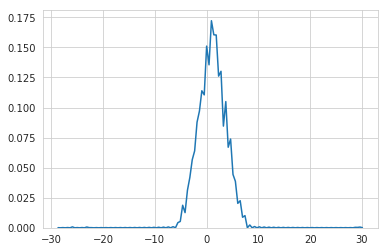

In [7]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(team_quality['beta']), bw=0.1)

The distribution seems to be symetric, with a little shift towards positive estimates. In general, very nice looking distribution.

If you have noticed, during quality estimation I used the `exp(beta)` to determine team's quality. The idea is, that the difference of i.e. `beta=1` and `beta=2` is not equivalent of the difference between `beta=2` and `beta=3`, as beta parameters are following not linear, but logarithmic interpretation (all this is the result of us using binomial `glm`). However, it is possible to get a linearly comparable team strengths - it is sufficient to apply `exp(beta)` transformation!

Let's take at the `exp(beta)` distribution:

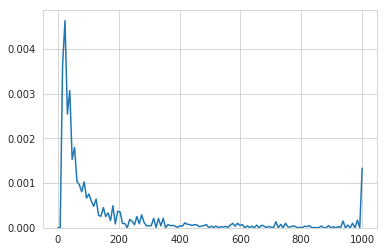

In [8]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(np.clip(team_quality['quality'],0,1000)), bw=0.1)

First thing we can notice, that there is a collection of teams with very high team strengths. This is where you would expect the tournament leaders to be!

# March Madness teams - team strength overview

Up until this point we considered all the teams which played in the regular season. However, we are only interested in March Madness selected teams. I am going to analyze how the team strength we calculated translates into predicting the winners of NCAA March Madness tournament matches.

Let's merge the team quality data to our tournament results table:

In [9]:
team_quality_T1 = team_quality[['TeamID','Season','quality']]
team_quality_T1.columns = ['T1_TeamID','Season','T1_quality']
team_quality_T2 = team_quality[['TeamID','Season','quality']]
team_quality_T2.columns = ['T2_TeamID','Season','T2_quality']

tourney_results['T1_TeamID'] = tourney_results['T1_TeamID'].astype(int)
tourney_results['T2_TeamID'] = tourney_results['T2_TeamID'].astype(int)
tourney_results = tourney_results.merge(team_quality_T1, on = ['T1_TeamID','Season'], how = 'left')
tourney_results = tourney_results.merge(team_quality_T2, on = ['T2_TeamID','Season'], how = 'left')

In [10]:
# we only have tourney results since year 2010
tourney_results = tourney_results.loc[tourney_results['Season'] >= 2010].reset_index(drop=True)

# not interested in pre-selection matches
tourney_results = tourney_results.loc[tourney_results['DayNum'] >= 136].reset_index(drop=True)

We are also going to be interested in comparing how the team strength we calculated correlates with seeds assigned to each team:

In [11]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds['division'] = seeds['Seed'].apply(lambda x: x[0])

seeds_T1 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T2 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed','T1_division']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed','T2_division']

tourney_results = tourney_results.merge(seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_results = tourney_results.merge(seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

Let's try and convert team quality to the rank of team quality:

In [12]:
tourney_results['T1_powerrank'] = tourney_results.groupby(['Season','T1_division'])['T1_quality'].rank(method='dense', ascending=False).astype(int)
tourney_results['T2_powerrank'] = tourney_results.groupby(['Season','T2_division'])['T2_quality'].rank(method='dense', ascending=False).astype(int)

At this point we are interested to see how the power rank we derived from regular season correlats with seed data:

In [13]:
piv = pd.pivot_table(tourney_results, index = ['T1_seed'], columns=['T1_powerrank'], values = ['T1_TeamID'], aggfunc=len)
piv = piv.xs('T1_TeamID', axis=1, drop_level=True)

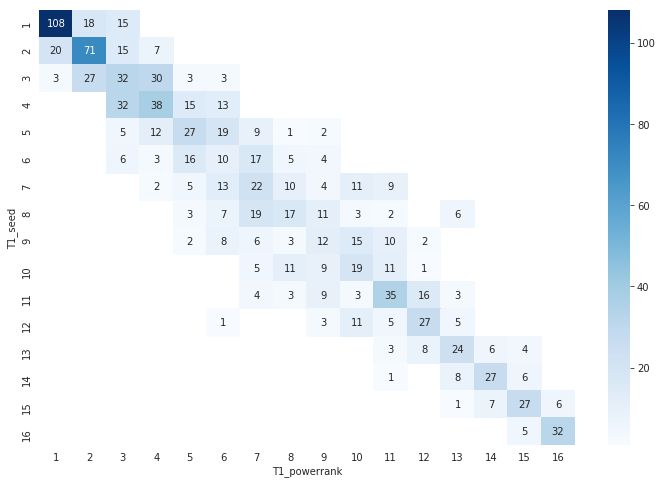

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(piv, annot=True,cmap='Blues', fmt='g')

There is a very strong correlation, but there are some interesting misalignments. For example, it is interesting how #1 seed is assigned - it seems our powerranking agrees only in `108/(108+18+15) = 76.5%` of the times with the number 1 seed selection! It can be easily explained - we did not capture any time component, like increasing/decreasing quality trend in our `glm` model. And the `seed` is capturing the end result of how the team is ready for the March Madness (like is all star players of the team are healthy?)

And there is a quite strong disagreement in the mid-level seeded teams - these are the hardest to rank even for experts!

So now we can finally raise a question - what is a better predictor - seed information or our power rankings?
Let's try and do that without building any models - let's simply calculate how many games a team won with a given seed/powerrank:

In [15]:
tourney_results['win'] = np.where(tourney_results['T1_Score'] > tourney_results['T2_Score'], 1, 0)

In [16]:
mean_win_ratio = pd.DataFrame({'seed_win_ratio': tourney_results.groupby('T1_seed')['win'].mean(),
                               'powerrank_win_ratio': tourney_results.groupby('T1_powerrank')['win'].mean()})
mean_win_ratio

,seed_win_ratio,powerrank_win_ratio
1,0.787234,0.763359
2,0.690265,0.698276
3,0.642857,0.676190
4,0.632653,0.608696
5,0.520000,0.492958
6,0.409836,0.527027
7,0.539474,0.560976
8,0.470588,0.280000
9,0.379310,0.333333
10,0.357143,0.419355


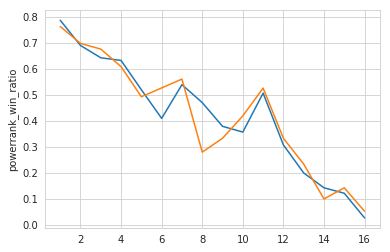

In [17]:
sns.set_style('whitegrid')
sns.lineplot(mean_win_ratio.index, mean_win_ratio['seed_win_ratio']) # Blue
sns.lineplot(mean_win_ratio.index, mean_win_ratio['powerrank_win_ratio']) # Orange

It seems they are pretty much aligned on average, and there are huge fluctuations in mid-range seeds as to be expected!

Let's take look at AUC of the seed/rank assignment:

In [18]:
from sklearn.metrics import roc_auc_score

print(f"seed AUC: {roc_auc_score(tourney_results['win'],-tourney_results['T1_seed'])}")
print(f"powerrank AUC: {roc_auc_score(tourney_results['win'],-tourney_results['T1_powerrank'])}")
print(f"team quality AUC: {roc_auc_score(tourney_results['win'],tourney_results['T1_quality'])}")

seed AUC: 0.721579898534631
powerrank AUC: 0.7145998774452625
team quality AUC: 0.6279483901470968


It seems that our powerrank is at very similar level expert based seed assignment! which is great news by itself - we have just proven that there is a way to build an unbiased seed ranking for the March Madness!

However, *raw* team quality estimate is a not doing as good as powerranks. The reason for that maybe is that we built quality models for each season separately. This is a food for thought both for you and for me!

So to summarize - estimating team quality with a very simple `glm` model should be helpful in determining the winner of a basketball match! And here you have it - a very strong features for your models!

## Hope you enjoyed this analysis!

### Liked the content? don't forget to upvote:)